In [1]:
import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Compare NVE modelled flows

Each year, NIVA receives modelled flow data from NVE based on output from a spatially distributed version of the HBV model. The data comprise daily discharge estimates for each vassdragsområde for the period from 1990 to the present year.

NVE data received up to and including 2020 (i.e. modelled years up to 2019) were based on a meteorological dataset called `seNorge-v1`. In 2021 (i.e. modelled years up to 2020), NVE switched to an updated version of the meteorological dataset called `seNorge-2018` (see e.g. [here](https://essd.copernicus.org/articles/11/1531/2019/) for a comparison of different seNorge data products).

This notebook compares mean flows for each vassdragsområde in different versions of the NVE data (i.e. `seNorge-v1` versus `seNorge-2018`). For each vassdragsområde, the code calculates the ratio

$$r_i = \frac{\overline{Q^i}_{2018}}{\overline{Q^i}_{v1}} $$

where $r_i$ is the ratio for vassdragsområde $i$; $\overline{Q^i}_{2018}$ is the mean daily flow for vassdragsområde $i$ based on `seNorge-2018`; and $\overline{Q^i}_{v1}$ is the mean daily flow for vassdragsområde $i$ based on `seNorge-v1` (all evaluated over the same time period, from 1990 to 2019).

In [2]:
def assign_marine_area(vassnr):
    """Assign (approximate) OSPAR marine area based on vassdragsområde."""
    if vassnr < 91:
        return "Nordsjøen"
    elif 91 <= vassnr < 171:
        return "Norskehavet"
    elif 171 <= vassnr < 248:
        return "Barentshavet"
    elif vassnr == 315:
        return "Nordsjøen"
    else:
        return "Sverige"

In [3]:
# Select NVE datasets to compare. Year represent the last year in the modelled data
# i.e. 2019 correspons to data received in 2020 etc.
# 2019 is the last year using seNorge-v1; 2020 is the first year using seNorge-2018
old_year, new_year = 2019, 2020

# Process raw NVE data
years = (old_year, new_year)
df_list = []
for year in years:
    data_fold = f"../../Data/hbv_modelled/RID_{year}"
    search_path = os.path.join(data_fold, "hbv_*.var")
    file_list = glob.glob(search_path)

    for file_path in file_list:
        name = os.path.split(file_path)[1]
        vass_nr = int(name.split("_")[1][:-4])
        df = pd.read_csv(
            file_path, delim_whitespace=True, header=None, names=["date", "flow_m3ps"]
        )
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d/1200")
        df["vassnr"] = vass_nr
        df["data_year"] = year

        # Truncate data from 1990 to 'old_year' so that we're comparing the same
        # period in each dataset (i.e. drop the last last from the 'new' dataset)
        df = df.query(f"'1990-01-01' <= date <= '{old_year}-12-31'")

        df_list.append(df)

# Combine and reshape
df = pd.concat(df_list, axis="rows")
df = df.groupby(["data_year", "vassnr"]).mean()["flow_m3ps"].reset_index()
df = df.set_index(["data_year", "vassnr"]).unstack("data_year")
df.columns = df.columns.get_level_values(1)
df.reset_index(inplace=True)
df["ratio"] = df[new_year] / df[old_year]
df["Område"] = df["vassnr"].apply(assign_marine_area)
df.columns.name = ""

display(df.head())
df.describe()

,vassnr,2019,2020,ratio,Område
0,1,37.995782,35.170221,0.925635,Nordsjøen
1,2,778.874820,624.095512,0.801278,Nordsjøen
2,3,12.386341,12.559976,1.014018,Nordsjøen
3,4,2.607849,2.617693,1.003775,Nordsjøen
4,5,3.493900,3.686976,1.055261,Nordsjøen


,vassnr,2019,2020,ratio
count,261.000000,261.000000,261.000000,261.000000
mean,133.865900,46.999705,38.195417,0.848902
std,80.961489,70.172699,55.964364,0.147328
min,1.000000,0.024310,0.000152,0.002737
25%,66.000000,12.560839,12.005735,0.745406
50%,131.000000,26.985775,21.869928,0.844796
75%,196.000000,55.493137,45.557498,0.935877
max,315.000000,778.874820,624.095512,1.351516


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3197: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


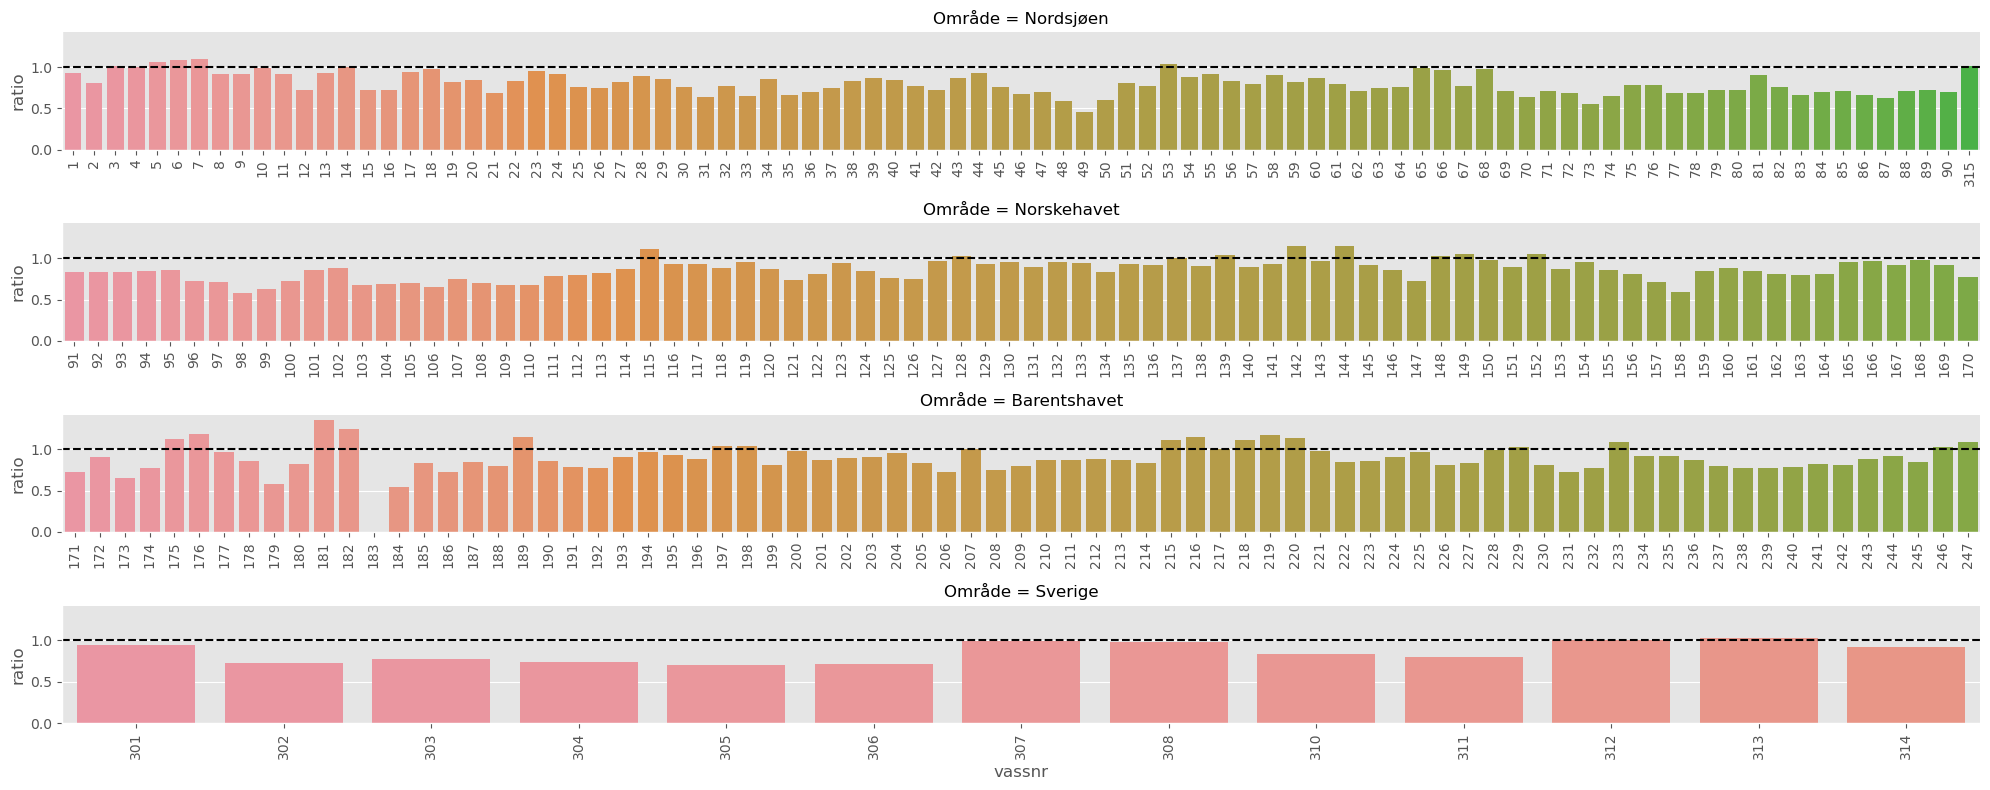

In [4]:
# Plot
g = sn.catplot(
    data=df,
    x="vassnr",
    y="ratio",
    row="Område",
    kind="bar",
    height=2,
    aspect=10,
    sharex=False,
)
g.set_xticklabels(rotation=90)
g.map(plt.axhline, y=1, ls="--", c="black")
plt.tight_layout()

There are some substantial differences between these two datasets. In particular, **mean flows in `seNorge-2018` are typically lower than in `seNorge-v1`**: on average, `seNorge-2018` flows are 85% of `seNorge-v1` (IQR from 75% to 94%). The most extreme example is vassdragområde 183, where flows are typically ~0.05 m3/s in the `seNorge-v1` dataset, but are almost always 0 using `seNorge-2018`.